## Basic definitions

In [1]:
import os

In [2]:
input_data_path=os.path.join('..','input','data')
stored_data_path = os.path.join('..','input','resnet-weights')
csv_filename='Data_Entry_2017.csv'

## Undersampling the majority class ("No finding" class)

In [3]:
import pandas as pd

In [4]:
all_xray_df = pd.read_csv(os.path.join(input_data_path,csv_filename))
mask = all_xray_df['Finding Labels']!='No Finding' # set all 'No Finiding' labels to 0 and rest to 1
ctr = 0
for i in range(mask.shape[0]):
    if mask[i]==0:
        ctr+=1
    if ctr%5==0:
        mask[i]=1  # select every 5th 'No Finding' label
# No Finding class reduced to 20%
all_xray_df = all_xray_df[mask].copy(deep=True)

In [5]:
from glob import glob

In [6]:
all_image_paths = {os.path.basename(f): f  for f in glob(os.path.join(input_data_path,'images*','*','*.png'))   }  
# create a dict mapping image names to their path
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 63831


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
102795,00027415_028.png,Nodule,28,27415,23,M,AP,3056,2544,0.139,0.139,NaN,../input/data/images_011/images/00027415_028.png
66614,00016480_002.png,Mass,2,16480,54,M,PA,2992,2991,0.143,0.143,NaN,../input/data/images_008/images/00016480_002.png
21780,00005778_001.png,Pneumonia,1,5778,59,M,PA,2500,2048,0.171,0.171,NaN,../input/data/images_003/images/00005778_001.png


## Visualisation

In [7]:
import matplotlib.pyplot as plt

In [8]:
# print the 15 most common labels in the column 'Finding Labels'
label_counts = all_xray_df['Finding Labels'].value_counts()[:15]
print((label_counts))

No Finding                  12072
Infiltration                 9547
Atelectasis                  4215
Effusion                     3955
Nodule                       2705
Pneumothorax                 2194
Mass                         2139
Effusion|Infiltration        1603
Atelectasis|Infiltration     1350
Consolidation                1310
Atelectasis|Effusion         1165
Pleural_Thickening           1126
Cardiomegaly                 1093
Emphysema                     892
Infiltration|Nodule           829
Name: Finding Labels, dtype: int64


In [9]:
import numpy as np

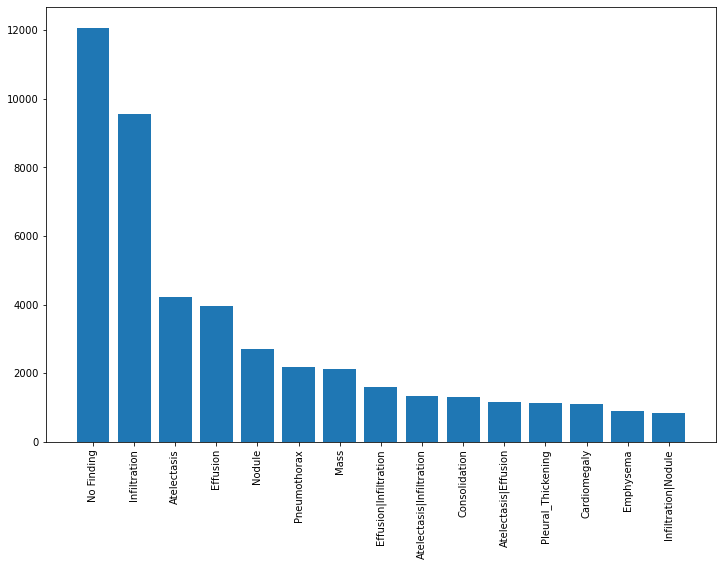

In [10]:
fig, ax = plt.subplots(1,1,figsize = (12, 8))
ax.bar(np.arange(len(label_counts))+0.5, label_counts)
ax.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax.set_xticklabels(label_counts.index, rotation = 90)

## Pre Processing

In [11]:
all_labels=set()
# create a set of the names of all diseases

In [12]:
def sep_diseases(x):
    list_diseases=x.split('|')
    for item in list_diseases:
        all_labels.add(item)
    return list_diseases

In [13]:
# Since the image may contain multiple disease labels
# Create a list of all disesases and append a new column named output to the x_ray dataframe
all_xray_df['disease_vec']=all_xray_df['Finding Labels'].apply(sep_diseases)

In [14]:
all_labels=list(all_labels)
all_labels.remove('No Finding')
all_labels.sort()

In [15]:
disease_freq={}
for sample in all_xray_df['disease_vec']:
    for disease in sample:
        if disease in disease_freq:
            disease_freq[disease]+=1
        else:
            disease_freq[disease]=1
print(disease_freq)

{'Cardiomegaly': 2776, 'Emphysema': 2516, 'Effusion': 13317, 'Hernia': 227, 'Infiltration': 19894, 'Mass': 5782, 'Nodule': 6331, 'No Finding': 12072, 'Atelectasis': 11559, 'Pneumothorax': 5302, 'Pleural_Thickening': 3385, 'Pneumonia': 1431, 'Fibrosis': 1686, 'Edema': 2303, 'Consolidation': 4667}


<BarContainer object of 15 artists>

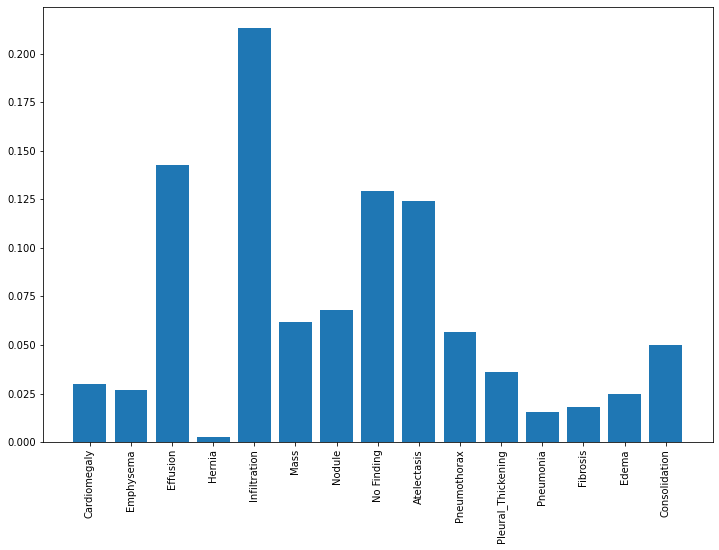

In [16]:
fig,ax=plt.subplots(1,1,figsize=(12,8))
plt.xticks(range(15),list(disease_freq.keys()), rotation = 90)
freq = np.array(list(disease_freq.values()))
percent = freq/np.sum(freq)
ax.bar(range(15),list(percent))

In [17]:
for label in all_labels:
    all_xray_df[label]=all_xray_df['disease_vec'].apply(lambda x: float(label in x))

In [18]:
# Glimpse of the pre-processed dataframe
all_xray_df.loc[:,'disease_vec':]

,disease_vec,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,[Cardiomegaly],0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"[Cardiomegaly, Emphysema]",0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"[Cardiomegaly, Effusion]",0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,[Hernia],0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,[Hernia],0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112106,"[Mass, Nodule]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
112108,[Pleural_Thickening],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
112112,[No Finding],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
112115,"[Mass, Pneumonia]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


## Splitting the dataset

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
# 15% of the data will be used for testing of model performance
# random state is set so as to get the same split everytime
train_df, test_df = train_test_split(all_xray_df,test_size = 0.15, random_state = 2020)
print('Number of training examples:', train_df.shape[0])
print('Number of validation examples:', test_df.shape[0])

Number of training examples: 54256
Number of validation examples: 9575


In [ ]:
# execute just once
train_df.to_csv('train_df.csv',index=False)
test_df.to_csv('test_df.csv',index=False)

In [21]:
# once saved , use the following statements to load train and test dataframes subsequently
train_df = pd.read_csv(os.path.join(stored_data_path,'train_df.csv'))
test_df = pd.read_csv(os.path.join(stored_data_path,'test_df.csv'))

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [23]:
#creating an Image Data generator
IMG_SIZE = (128, 128)
core_idg = ImageDataGenerator(rescale=1.0/255.0, validation_split = 0.06)

In [24]:
# obtaing the training images using the above generator
train_gen = core_idg.flow_from_dataframe(
        dataframe=train_df,
        directory=None,
        x_col='path',
        y_col=all_labels,
        target_size=(128, 128),
        batch_size=64,
        class_mode='raw',
        classes=all_labels,
        shuffle=True,
        color_mode = "grayscale",
        subset='training')

/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:220: UserWarning: `classes` will be ignored given the class_mode="raw"
  .format(self.class_mode))


Found 51001 validated image filenames.


In [25]:
# obtaing the validation images using the above generator
valid_gen = core_idg.flow_from_dataframe(
        dataframe=train_df,
        directory=None,
        x_col='path',
        y_col=all_labels,
        target_size=(128, 128),
        batch_size=64,
        class_mode='raw',
        classes=all_labels,
        shuffle=False,
        color_mode = "grayscale",
        subset='validation')

Found 3255 validated image filenames.


In [26]:
def compute_freq(ground_labels):
    num_samples = ground_labels.shape[0]
    pos_samples = np.sum(ground_labels,axis=0)
    neg_samples = num_samples-pos_samples
    pos_samples = pos_samples/float(num_samples)
    neg_samples = neg_samples/float(num_samples)
    return pos_samples, neg_samples

In [27]:
import tensorflow.keras.backend as K

In [28]:
freq_pos , freq_neg = compute_freq(train_gen.labels)
print(freq_pos)
print(freq_neg)

[0.1816435  0.04266583 0.07350836 0.03658752 0.20778024 0.04013647
 0.02625439 0.00358816 0.31268014 0.09101782 0.09888041 0.05297935
 0.02225447 0.08274348]
[0.8183565  0.95733417 0.92649164 0.96341248 0.79221976 0.95986353
 0.97374561 0.99641184 0.68731986 0.90898218 0.90111959 0.94702065
 0.97774553 0.91725652]


In [29]:
# assign negative class frequency as positive class weights and vice versa
weights_pos = K.constant(freq_neg,dtype='float32')
weights_neg = K.constant(freq_pos,dtype='float32')
epsilon=1e-7

In [30]:
# weighted loss function to handle class imbalance
def weighted_loss(y_true, y_pred):
    loss = 0.0
    loss_pos = -1 * K.sum( weights_pos * y_true * K.log(y_pred + epsilon), axis=-1)
    loss_neg = -1 * K.sum( weights_neg * (1 - y_true) * K.log(1 - y_pred + epsilon) ,axis=-1)
    return (loss_pos+loss_neg)/len(all_labels)

## Creating model using Keras Functional Model

In [31]:
from tensorflow.keras import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import  Conv2D, BatchNormalization, Activation, Input, AveragePooling2D, Dense, Dropout, Flatten

In [32]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [33]:
import tensorflow as tf

In [34]:
def resnet_v2(input_shape, depth,num_classes):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = tf.keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu',name='last_activation_layer')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='sigmoid',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [35]:
multi_disease_model = resnet_v2((128,128,1),(9*6)+2,len(all_labels))
multi_disease_model.compile(optimizer = 'adam', loss = weighted_loss)
multi_disease_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [36]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("resnet_weights_latest{epoch:02d}.h5", verbose=1, save_weights_only = True)

In [37]:
initial_epoch = 0
epochs = 30

In [ ]:
# start the training
hist = multi_disease_model.fit(train_gen, initial_epoch = initial_epoch, epochs = epochs, callbacks = [checkpoint])

In [ ]:
# save the loss on training set for all epochs
np.save('loss'+str(epochs)+'.npy',np.array(hist.history['loss']))

## Visualising training

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
val_loss = []
for i in range(30):
    multi_disease_model.load_weights(os.path.join(stored_data_path,'weights_epoch_%02d.h5'%(i+1)))
    cur_loss = multi_disease_model.evaluate(valid_gen, verbose = 1)
    val_loss.append(cur_loss)
np.save('validation_loss.npy',np.array(val_loss))

In [101]:
training_loss = np.load(os.path.join(stored_data_path,'training_loss.npy'))
val_loss = np.load(os.path.join(stored_data_path,'validation_loss.npy'))

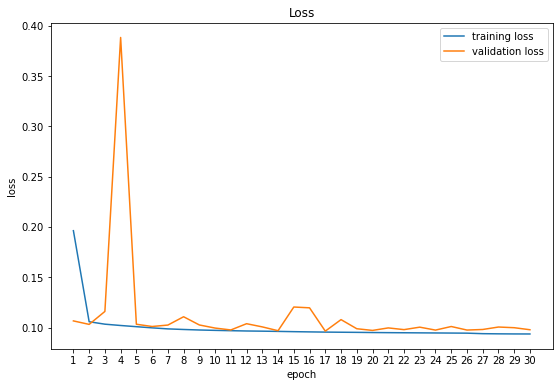

In [103]:
# plot loss on training and validation set
fig , axis = plt.subplots(1,1,figsize = (9,6))
axis.plot(range(1,training_loss.shape[0]+1),training_loss,label="training loss")
axis.plot(range(1,val_loss.shape[0]+1),val_loss,label="validation loss")
axis.legend()
plt.xticks(range(1,training_loss.shape[0]+1))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss')
plt.show()
fig.savefig('loss.png')

In [106]:
from sklearn.metrics import roc_curve, auc

In [111]:
def print_roc_curve(gen, model,filename):
    pred_labels = model.predict(gen, verbose = 1)
    fig, ax = plt.subplots(1,1, figsize = (9, 9))
    auc_list = []
    for (idx, class_label) in enumerate(all_labels):
        fpr, tpr, thresholds = roc_curve(gen.labels[:,idx].astype(int), pred_labels[:,idx])
        cur_auc = auc(fpr,tpr)
        auc_list.append(cur_auc)
        ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (class_label, cur_auc))
    ax.legend()
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    fig.savefig(filename)
    auc_list = np.array(auc_list)
    return auc_list

In [112]:
auc_epochs = []

Epoch 5
51/51 [==============================] - 53s 1s/step


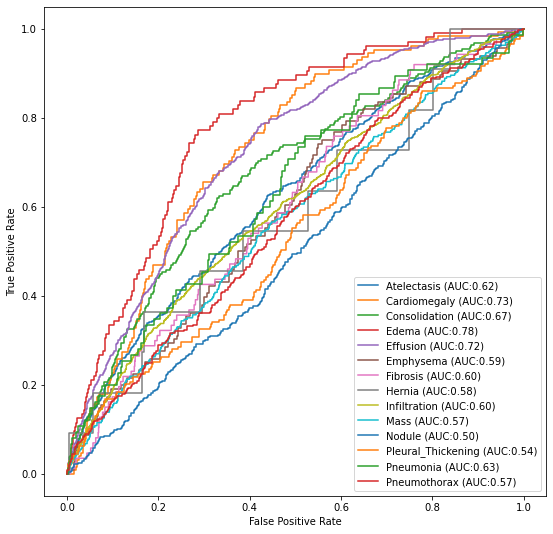

In [113]:
print("Epoch 5")
multi_disease_model.load_weights(os.path.join(stored_data_path,"weights_epoch_05.h5"))
auc_5 = print_roc_curve(valid_gen, multi_disease_model,'val_set_roc_curve_epoch_05.png')
auc_epochs.append(auc_5)

Epoch 10
51/51 [==============================] - 54s 1s/step


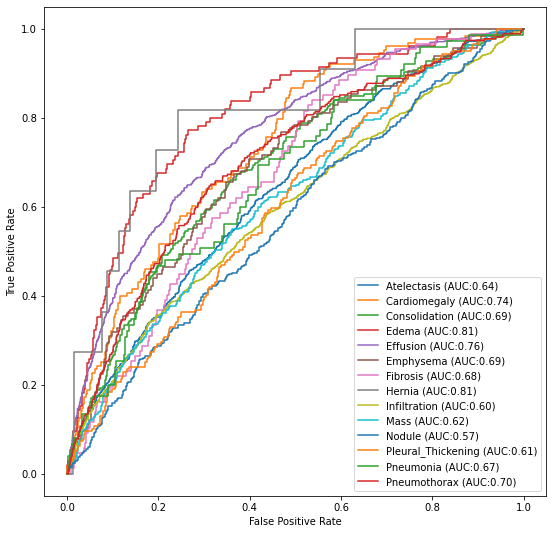

In [114]:
print("Epoch 10")
multi_disease_model.load_weights(os.path.join(stored_data_path,"weights_epoch_10.h5"))
auc_10 = print_roc_curve(valid_gen, multi_disease_model,'val_set_roc_curve_epoch_10.png')
auc_epochs.append(auc_10)

Epoch 15
51/51 [==============================] - 54s 1s/step


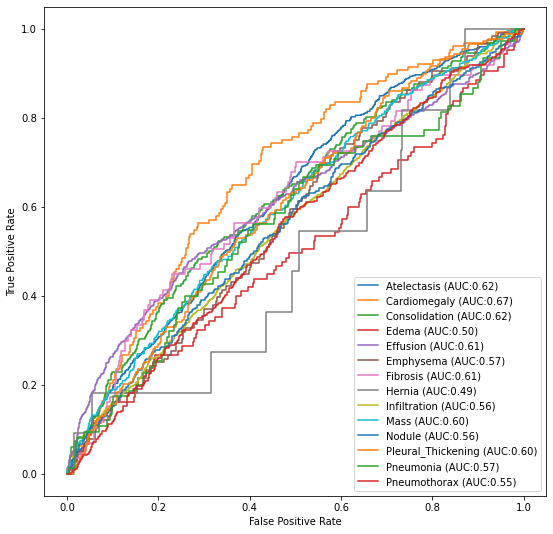

In [115]:
print("Epoch 15")
multi_disease_model.load_weights(os.path.join(stored_data_path,"weights_epoch_15.h5"))
auc_15 = print_roc_curve(valid_gen, multi_disease_model,'val_set_roc_curve_epoch_15.png')
auc_epochs.append(auc_15)

Epoch 20
51/51 [==============================] - 54s 1s/step


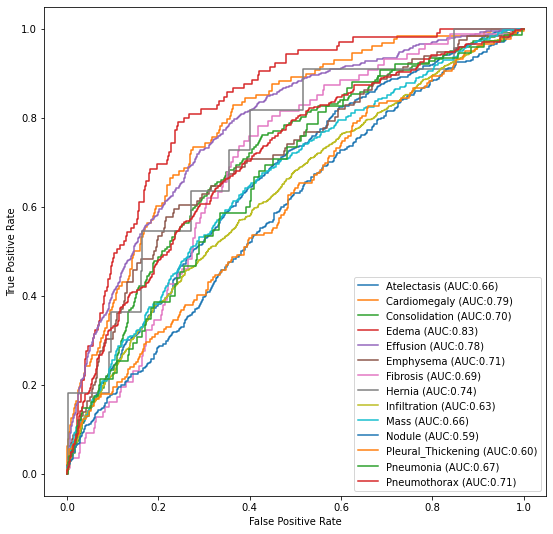

In [116]:
print("Epoch 20")
multi_disease_model.load_weights(os.path.join(stored_data_path,"weights_epoch_20.h5"))
auc_20 = print_roc_curve(valid_gen, multi_disease_model,'val_set_roc_curve_epoch_20.png')
auc_epochs.append(auc_20)

Epoch 25
51/51 [==============================] - 54s 1s/step


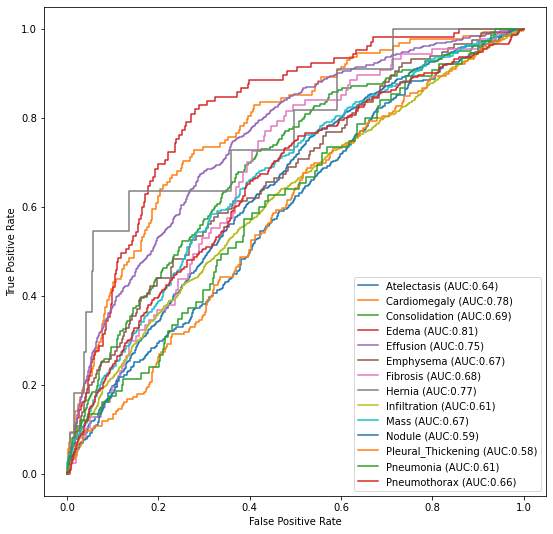

In [117]:
print("Epoch 25")
multi_disease_model.load_weights(os.path.join(stored_data_path,"weights_epoch_25.h5"))
auc_25 = print_roc_curve(valid_gen, multi_disease_model,'val_set_roc_curve_epoch_25.png')
auc_epochs.append(auc_25)

Epoch 30
51/51 [==============================] - 54s 1s/step


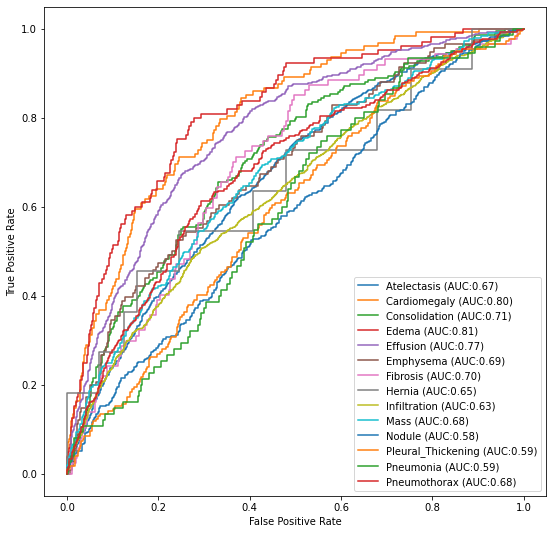

In [118]:
print("Epoch 30")
multi_disease_model.load_weights(os.path.join(stored_data_path,"weights_epoch_30.h5"))
auc_30 = print_roc_curve(valid_gen, multi_disease_model,'val_set_roc_curve_epoch_30.png')
auc_epochs.append(auc_30)

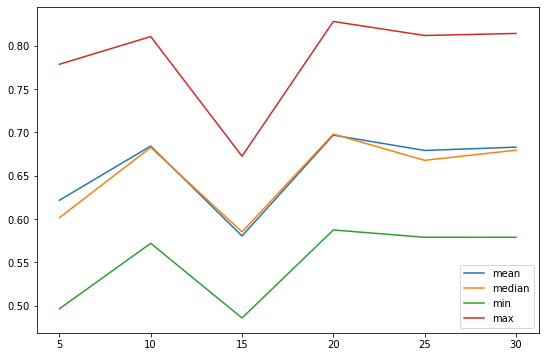

In [119]:
auc_epochs =np.array(auc_epochs)
x_labels = [5,10,15,20,25,30]
fig , axis = plt.subplots(1,1,figsize = (9,6))
axis.plot(x_labels,np.mean(auc_epochs,axis = 1),label="mean")
axis.plot(x_labels,np.median(auc_epochs,axis = 1),label="median")
axis.plot(x_labels,np.min(auc_epochs,axis = 1),label="min")
axis.plot(x_labels,np.max(auc_epochs,axis = 1),label="max")
axis.legend()
plt.xticks(x_labels)
plt.show()

In [120]:
print(np.mean(auc_epochs,axis = 1))
print(np.median(auc_epochs,axis = 1))
print(np.min(auc_epochs,axis = 1))
print(np.max(auc_epochs,axis = 1))

[0.6215941  0.68419547 0.58040889 0.69679318 0.6790869  0.68288168]
[0.60148678 0.68261269 0.58501625 0.69796406 0.66766592 0.67945873]
[0.49634395 0.57190883 0.4857359  0.58731002 0.57888246 0.57886972]
[0.77857899 0.81053133 0.67243714 0.8279607  0.81176115 0.81413757]


## Testing

In [ ]:
# from the above graph, we can infer that the model generalises well at epoch 20
# hence, we use model weights corresponding to epoch 20 for testing

In [121]:
test_idg = ImageDataGenerator(rescale=1.0/255.0)
test_gen = test_idg.flow_from_dataframe(
        dataframe=test_df,
        directory=None,
        x_col='path',
        y_col=all_labels,
        target_size=(128, 128),
        batch_size=64,
        classes=all_labels,
        class_mode='raw',
        color_mode = "grayscale",
        shuffle=False)

/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:220: UserWarning: `classes` will be ignored given the class_mode="raw"
  .format(self.class_mode))


Found 9575 validated image filenames.


150/150 [==============================] - 162s 1s/step


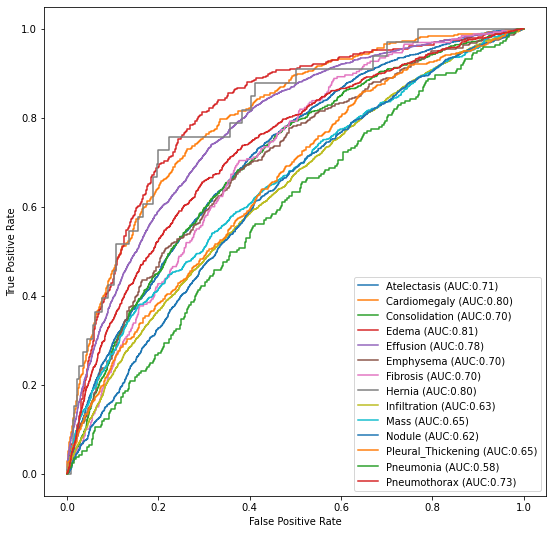

In [122]:
multi_disease_model.load_weights(os.path.join(stored_data_path,"weights_epoch_20.h5"))
auc_test = print_roc_curve(test_gen, multi_disease_model,'test_set_roc_curve.png')

In [126]:
np.save("test_set_auc.npy",auc_test)
print(auc_test)

[0.71045197 0.80070432 0.70077416 0.8115148  0.77582029 0.69673487
 0.70355692 0.80436094 0.63133665 0.65237521 0.62267122 0.65270756
 0.58425993 0.73021768]


In [253]:
print("Model performance on Test data")
print("min auc =",np.min(auc_test))
print("max auc =",np.max(auc_test))
print("mean auc = ",np.mean(auc_test))
print("median auc = ",np.median(auc_test))

Model performance on Test data
min auc = 0.5842599338052683
max auc = 0.8115148031268208
mean auc =  0.7055347530894733
median auc =  0.7021655415560375


## Heat map using Grad Cam

In [208]:
from tensorflow.keras.preprocessing.image import img_to_array
import cv2

In [209]:
multi_disease_model.load_weights('../input/resnet-weights/weights_epoch_20.h5')
pred_test = multi_disease_model.predict(test_gen, verbose = 1)

150/150 [==============================] - 155s 1s/step


In [247]:
img_idx = [] #list of random indices
img_path = [] # list of random image paths corresponding to the above indices
all_idx = list(range(test_df.shape[0])) 
for i in range(len(all_labels)):
    idx = np.random.choice(np.argsort(pred_test[:,i])[-100:])
    print(idx,end=" ")
    img_idx.append(idx)
    img_path.append(test_df.path.iloc[idx])

8055 3266 8819 2705 6999 3870 1323 8188 7906 6857 1353 6461 3844 4127 

In [248]:
img_array = []
for i in range(len(all_labels)) :
  cur_path = img_path[i]
  img = cv2.imread(cur_path,0)
  img = cv2.resize(img,IMG_SIZE)
  img_array.append(img_to_array(img,dtype='float32'))
img_array = np.array(img_array)
print(img_array.shape)

(14, 128, 128, 1)


In [249]:
def find_target_layer():
  for layer in reversed(multi_disease_model.layers):
    if len(layer.output_shape) == 4:
      return layer.name

In [250]:
from tensorflow.keras import Model

In [251]:
def gen_heatmap(input_image,target_class):
    target_layer = multi_disease_model.get_layer(find_target_layer())
    gradModel = Model(inputs = [multi_disease_model.inputs],
                      outputs = [target_layer.output, multi_disease_model.output])
    with tf.GradientTape() as tape:
        convOutputs, pred = gradModel(input_image)
        loss = pred[:,target_class]
    grads = tape.gradient(loss, convOutputs)           
    # use automatic differentiation to compute the gradients
    
    castConvOutputs = tf.cast(convOutputs > 0, "float32")
    castGrads = tf.cast(grads > 0, "float32")
    guidedGrads = castConvOutputs * castGrads * grads  
    # compute the guided gradients
    
    convOutputs = convOutputs[0]
    guidedGrads = guidedGrads[0]
    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
    heatmap = cv2.resize(cam.numpy(), IMG_SIZE)
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + epsilon  # normalize the heatmap such that all values lie in the range
    heatmap = numer / denom                            # [0, 1], scale the resulting values to the range [0, 255]
    heatmap = (heatmap * 255).astype("uint8")          # and then convert to an unsigned 8-bit integer
    return heatmap

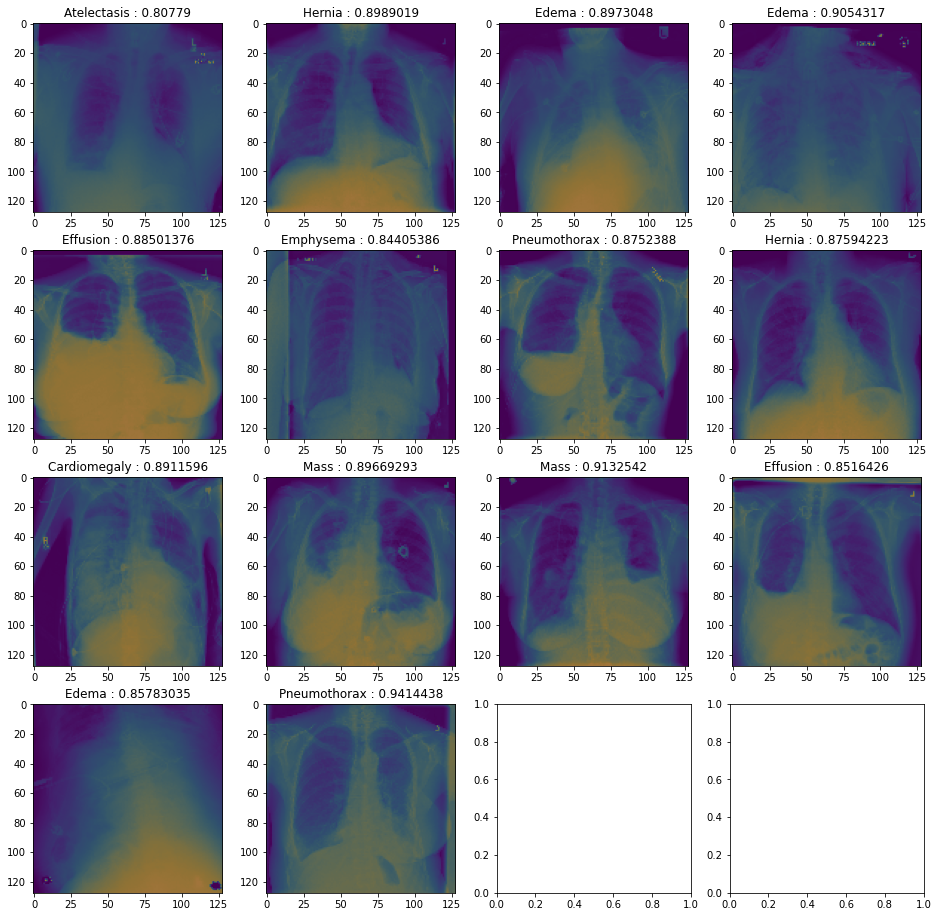

In [252]:
fig, axs = plt.subplots(4, 4,figsize=(16,16))
i = 0
j = 0
for k in range(len(all_labels)):
    idx = img_idx[k]
    target = np.argmax(pred_test[idx,:]) # select target class as the one with highest probability
    heatmap = gen_heatmap(img_array[k:k+1],target)
    axs[i,j].imshow(img_array[k,:,:,0].astype("uint8"))
    axs[i,j].imshow(heatmap,alpha=0.5)
    axs[i,j].set_title(all_labels[target]+" : "+str(pred_test[idx,target]))
    j+=1
    if j==4:
        i += 1
        j = 0
fig.savefig("xray_samples.png")